<a href="https://colab.research.google.com/github/Felipe0Parra/IO/blob/main/IO_Entrega2_E05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 2 Instrumentos ópticos

## Librerías:

In [1]:
# prompt: instala pint

!pip install pint
import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity


In [2]:
import numpy as np
import scipy as sp
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift, ifftshift
import imageio
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
import pint

from PIL import Image

u = pint.UnitRegistry()

## Funciones auxiliares:

Abrir URL:

In [3]:
def URL_ADAP(URL):
    URL = str(URL)
    URL2 = URL.replace('\\', '/')
    return URL2

Normalizar una matriz:

In [4]:
def normalize_image(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

Muestra de los espectros:

In [5]:
def ploteo_complejo(mat, indicador, escala):
    # mat es la matriz compleja que vamos a plotear
    if indicador == "I":
        mat = np.abs(mat)**2
    elif indicador == "A":
        mat = np.abs(mat)
    elif indicador == "P":
        mat = np.angle(mat)
    else:
        mat = mat
    if escala == 1:
        plt.figure()
        plt.imshow(mat)
        plt.show()
    else:
        plt.figure()
        plt.imshow(np.log(mat + 0.00001))
        plt.show()
    return 0

# Punto 3:

## Numeral a)

El objetivo del codigo de este numeral es desarrollar una transmitancia, correspondiente a un diafragma presente en el punto focal de una sistema de dos lentes convergentes, de tal forma que se identifique y elimine el ruido correspondiente a la imagen tanto como sea posible, implementando diferentes tecnicas.

In [6]:
imagen_ruido = cv2.imread('Ruido_E05.png', 0)

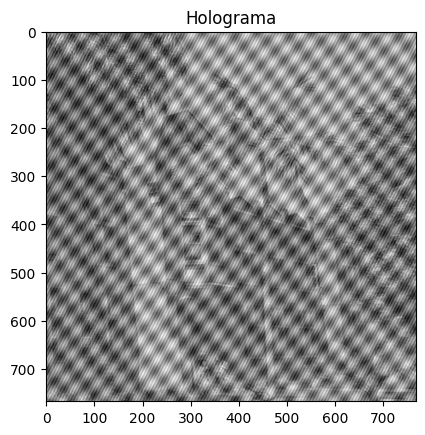

In [7]:
plt.figure()
plt.imshow(imagen_ruido, cmap = 'gray')
plt.title('Holograma')
plt.show()

In [8]:
img_norm_entrega = normalize_image(imagen_ruido)
print(f"Valor maximo del pixel de la imagen: {np.max(img_norm_entrega)} y valor minimo: {np.min(img_norm_entrega)}")

Valor maximo del pixel de la imagen: 1.0 y valor minimo: 0.0


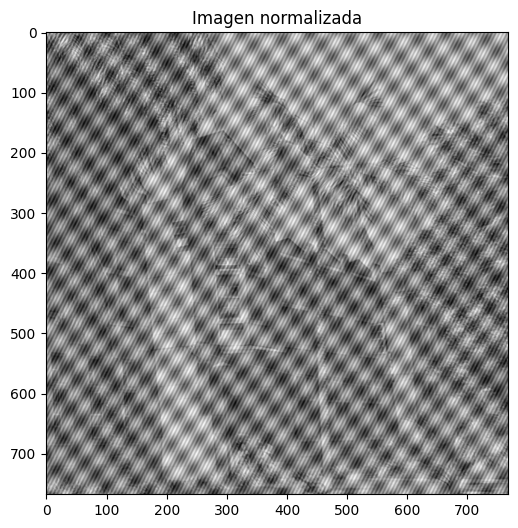

In [9]:
plt.figure(figsize = (8, 6))
plt.imshow(img_norm_entrega, cmap = 'gray')
plt.title('Imagen normalizada')
plt.show()

In [10]:
print(f"Cantidad de pixeles por eje de la imagen: {np.shape(img_norm_entrega)}")

Cantidad de pixeles por eje de la imagen: (768, 768)


FFT de la imagen entrante:

In [11]:
fft_imagen_ruido = fftshift(fft2(img_norm_entrega))

## Representación numerica de la función pupila:

In [12]:
pupila = np.ones(np.shape(img_norm_entrega), dtype = "uint8")
coordx = int(np.shape(img_norm_entrega)[0]/2)
coordy = int(np.shape(img_norm_entrega)[1]/2)
cv2.circle(pupila, (coordy, coordx), 14, 0, -1)            # Atención a lo que pasa aqui con las coordenadas

pupila = pupila

Normalizando:

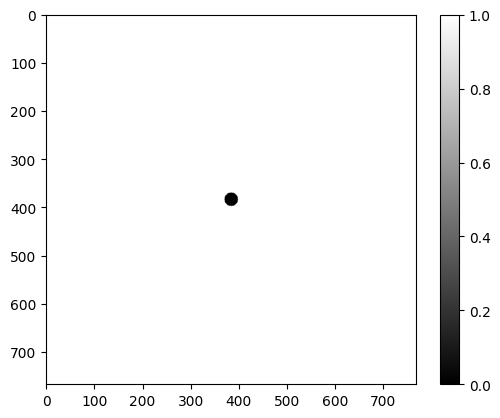

In [13]:
pupila_norm = normalize_image(pupila)

plt.imshow(pupila_norm, cmap = 'gray')
plt.colorbar()
plt.show()

Una multiplicación en el espacio de las frecuencias es igual a una convolución en el espacio de coordenadas.

Visualización del espectro de la imagen con ruido:

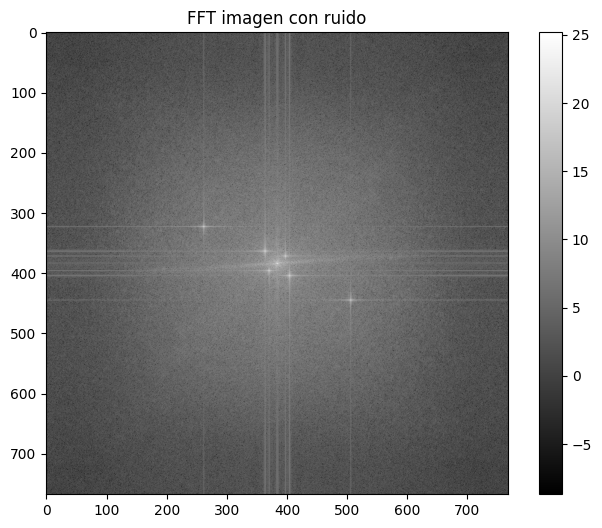

In [14]:
matriz_fft = np.log(0.0001 + np.abs(fft_imagen_ruido)**2)

plt.figure(figsize = (8, 6))
plt.imshow(matriz_fft, cmap = 'gray')
plt.title("FFT imagen con ruido")
plt.colorbar()
plt.show()

Para poder identificar y extraer automaticamente los picos discretos presentes en el espectro de la imagen correspondientes al ruido, usaremos una función pupila simple(pupila circular nula en el centro con un radio de 12 en el espacio de frecuencias) como tecnica unicamente de analisis, de tal forma que se puedan ignorar las bajas frecuencias que forman la imagen en el proceso posterior donde se clasifiquen picos a partir de un umbral de intensidad en el grafico:

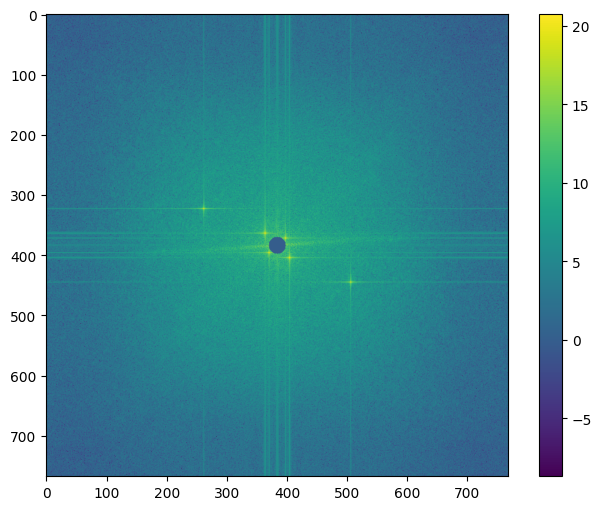

In [15]:
fft_lowf_exclude = matriz_fft * pupila_norm

plt.figure(figsize = (8, 6))
plt.imshow(fft_lowf_exclude)
plt.colorbar()
plt.show()

Pero si eso es solo por visualización, como voy a reconstruir la imagen luego?

## Booleanización de la FFT de la imagen para generación de una máscara para filtrado de ruido particular y automatica.

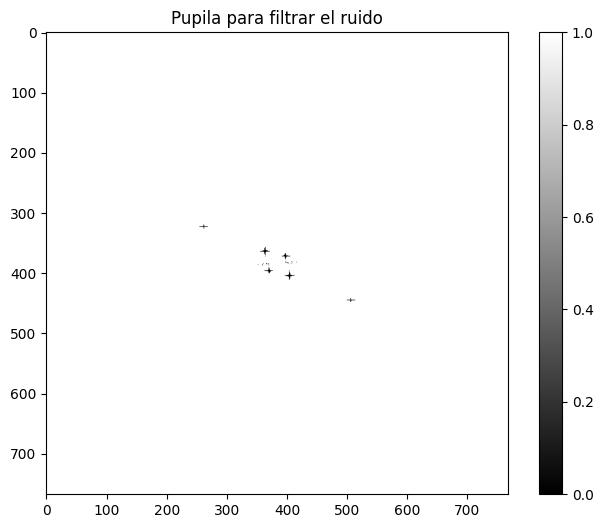

In [16]:
matriz_bool = 1 - np.where(fft_lowf_exclude > 14, 1, 0)


plt.figure(figsize = (8, 6))
plt.imshow(matriz_bool, cmap= 'gray')
plt.title("Pupila para filtrar el ruido")
plt.colorbar()
plt.show()

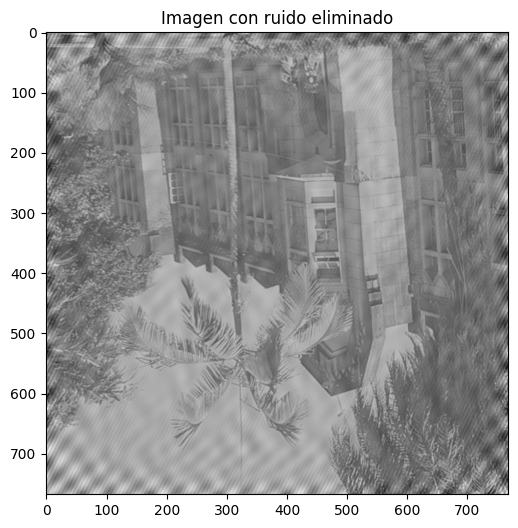

In [17]:
imagen_filtrada = normalize_image(np.abs(fft2(matriz_bool * fft_imagen_ruido)))

plt.figure(figsize = (8, 6))
plt.imshow(imagen_filtrada, cmap = 'gray')
plt.title('Imagen con ruido eliminado')
plt.show()

In [18]:
plt.imsave(r'C:\Users\Felipe\Pictures\Optica_Proyecto\IMG_sin_ruido.png', imagen_filtrada, cmap = 'gray')

Usar el metodo de los puntos rojos para poner circulos grandes en los picos identificados, para tapar de mejor manera el ruido sin perder información del centro del espectro.

## Notas importantes a)

- Revisar lo de la teoria de formación de imagenes de Abbe, para ver si se pueden saber las caracteristicas fisicas de el espectro, tamaño, coordenadas, etc.
- Lo que es pequeño en la imagen es grande en su espectro y viceversa.
- Hay una proporción especifica entre los periodos de un ruido periodico, por ejemplo, y las posiciones relativas al centro de los puntos luminosos, depende de lo visto en el teorema de muestreo y la teoria de difracción.

## Otros analisis de pulido

Los picos mayores a 6.5 corresponden entonces a:

In [19]:
magnitud_espectro = normalize_image(fft_lowf_exclude)
print(f"Maximo y minimo valor del espectro: {np.max(magnitud_espectro)} y {np.min(magnitud_espectro)}.")

Maximo y minimo valor del espectro: 1.0 y 0.0.


In [20]:
umbral = np.max(np.abs(magnitud_espectro)) * 0.96   # Valor para el cual garantizamos que solo los puntos mas luminosos son observables

picos = np.argwhere(magnitud_espectro > umbral)
valores_picos = magnitud_espectro[picos[:, 0], picos[:, 1]]  # Me muestra el valor en las coordenadas indentificadas

# Convertir coordenadas a frecuencias normalizadas
filas, columnas = magnitud_espectro.shape
frecuencias_x = (picos[:, 1] - columnas // 2) / columnas
frecuencias_y = (picos[:, 0] - filas // 2) / filas
frecuencias = np.column_stack((frecuencias_x, frecuencias_y))

# Imprimir coordenadas y valores de los picos
print("Picos detectados:")
for i, (f, v) in enumerate(zip(frecuencias, valores_picos)):
    print(f"Pico {i + 1}: Frecuencia en pixeles (x, y) = ({f[0]:.4f}, {f[1]:.4f}), Intensidad = {v:.2f}")

Picos detectados:
Pico 1: Frecuencia en pixeles (x, y) = (-0.1589, -0.0794), Intensidad = 1.00
Pico 2: Frecuencia en pixeles (x, y) = (-0.0260, -0.0260), Intensidad = 0.98
Pico 3: Frecuencia en pixeles (x, y) = (0.0182, -0.0156), Intensidad = 0.98
Pico 4: Frecuencia en pixeles (x, y) = (-0.0182, 0.0156), Intensidad = 0.98
Pico 5: Frecuencia en pixeles (x, y) = (0.0260, 0.0260), Intensidad = 0.98
Pico 6: Frecuencia en pixeles (x, y) = (0.1589, 0.0794), Intensidad = 1.00


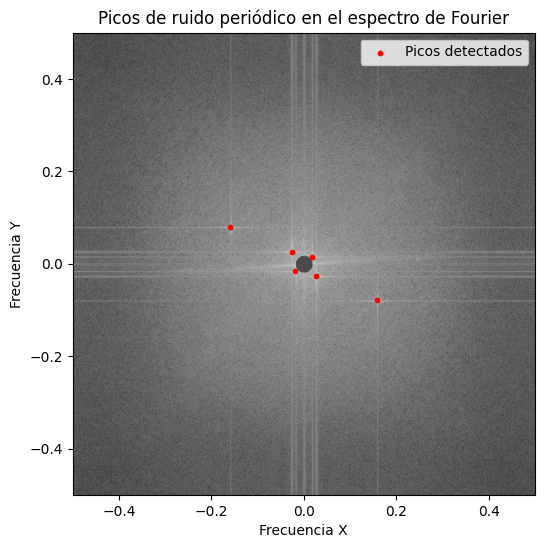

In [21]:
# Mostrar el espectro con los picos detectados
plt.figure(figsize = (8, 6))
plt.imshow(magnitud_espectro, cmap='gray', extent=(-0.5, 0.5, -0.5, 0.5))
plt.scatter(frecuencias_x, -frecuencias_y, color = 'red', s = 10, label = 'Picos detectados')
plt.title('Picos de ruido periódico en el espectro de Fourier')
plt.xlabel('Frecuencia X')
plt.ylabel('Frecuencia Y')
plt.legend()
plt.show()

Con las posiciones de los picos ahora puedo dibujar figuras con mejor precision.

## Tecnica de dibujo sobre imagen para optimización de la construcción de la pupila

In [22]:
from matplotlib.cm import ScalarMappable

In [23]:
# Convertir coordenadas a frecuencias normalizadas
filas, columnas = magnitud_espectro.shape
frecuencias_xN = picos[:, 1]
frecuencias_yN = picos[:, 0]
frecuenciasN = np.column_stack((frecuencias_xN, frecuencias_yN))

# Imprimir coordenadas y valores de los picos
print("Picos detectados:")
for o, (fN, vN) in enumerate(zip(frecuenciasN, valores_picos)):
    print(f"Pico {o + 1}: Frecuencia en pixeles (x, y) = ({fN[0]:.4f}, {fN[1]:.4f}), Intensidad = {vN:.2f}")

Picos detectados:
Pico 1: Frecuencia en pixeles (x, y) = (262.0000, 323.0000), Intensidad = 1.00
Pico 2: Frecuencia en pixeles (x, y) = (364.0000, 364.0000), Intensidad = 0.98
Pico 3: Frecuencia en pixeles (x, y) = (398.0000, 372.0000), Intensidad = 0.98
Pico 4: Frecuencia en pixeles (x, y) = (370.0000, 396.0000), Intensidad = 0.98
Pico 5: Frecuencia en pixeles (x, y) = (404.0000, 404.0000), Intensidad = 0.98
Pico 6: Frecuencia en pixeles (x, y) = (506.0000, 445.0000), Intensidad = 1.00


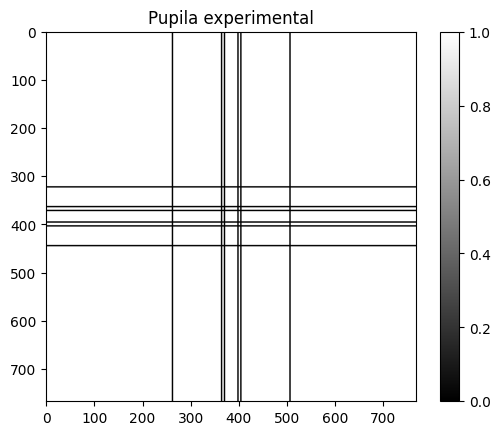

In [24]:
# Crear una imagen en blanco para ilustrar el dibujo (512x512 píxeles)
pupila_exp = np.ones((768, 768))
grosor_pupil_exp = 2

cv2.line(pupila_exp, (262, 0), (262, 768), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (0, 323), (768, 323), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (364, 0), (364, 768), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (0, 364), (768, 364), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (398, 0), (398, 768), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (0, 372), (768, 372), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (370, 0), (370, 768), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (0, 396), (768, 396), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (404, 0), (404, 768), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (0, 404), (768, 404), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (506, 0), (506, 768), 0, grosor_pupil_exp)
cv2.line(pupila_exp, (0, 445), (768, 445), 0, grosor_pupil_exp)


plt.imshow(pupila_exp, cmap = 'gray')
plt.title("Pupila experimental")
plt.colorbar()
plt.show()

## Probando la pupila experimental

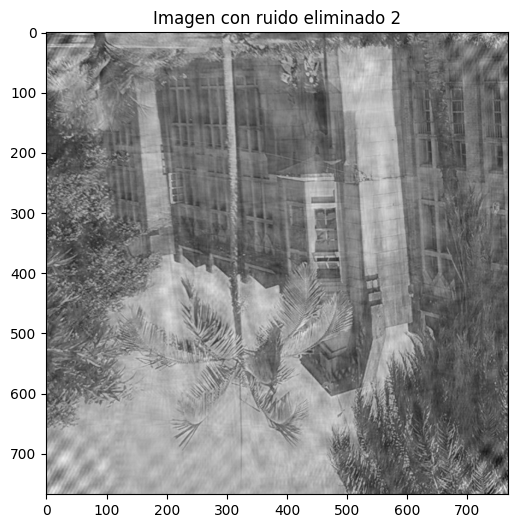

In [25]:
imagen_filtrada2 = normalize_image(np.abs(fft2(pupila_exp * fft_imagen_ruido)))

plt.figure(figsize = (8, 6))
plt.imshow(imagen_filtrada2, cmap = 'gray')
plt.title('Imagen con ruido eliminado 2')
plt.show()

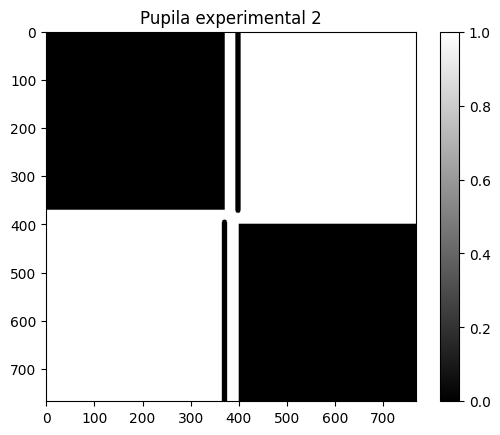

In [26]:
# Crear una imagen en blanco para ilustrar el dibujo (512x512 píxeles)
pupila_exp2 = np.ones((768, 768))

cv2.rectangle(pupila_exp2, (370, 370), (0, 0), 0, -1)
cv2.rectangle(pupila_exp2, (400, 400), (768, 768), 0, -1)
cv2.line(pupila_exp2, (370, 396), (370, 768), 0, 10)
cv2.line(pupila_exp2, (398, 372), (398, 0), 0, 10)

plt.imshow(pupila_exp2, cmap = 'gray')
plt.title("Pupila experimental 2")
plt.colorbar()
plt.show()

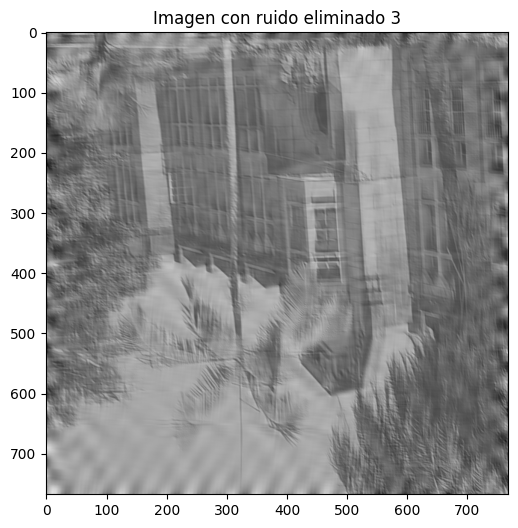

In [27]:
imagen_filtrada3 = normalize_image(np.abs(fft2(pupila_exp2 * fft_imagen_ruido)))

plt.figure(figsize = (8, 6))
plt.imshow(imagen_filtrada3, cmap = 'gray')
plt.title('Imagen con ruido eliminado 3')
plt.show()

## Comparaciones y comprobaciones

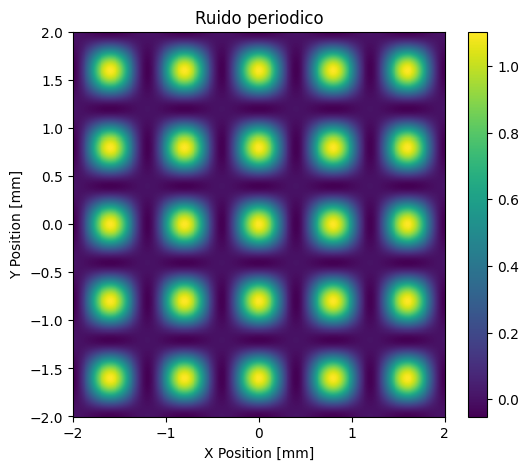

In [28]:
x = np.linspace(-2, 2, np.shape(img_norm_entrega)[0])
xv, yv = np.meshgrid(x, x)

m = 1.1
L = 0.8
franjas_ex = (0.5 + 0.5 * m * np.cos((xv/L) * 2 * np.pi)) * (0.5 + 0.5 * m * np.cos((yv/L) * 2 * np.pi))

plt.figure(figsize = (6, 5))

mesh = plt.pcolormesh(xv, yv, franjas_ex)

plt.colorbar(mesh)
plt.xlabel('X Position [mm]')
plt.ylabel('Y Position [mm]')
plt.title('Ruido periodico')
plt.show()

Probando tambien con su parte binaria:

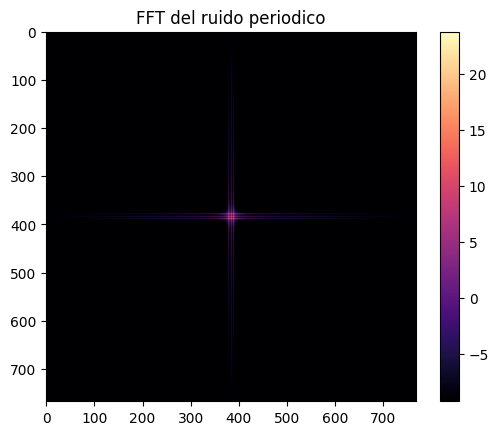

In [29]:
fft_armonic = fftshift(fft2(franjas_ex))

plt.imshow(np.log(0.0001 + np.abs(fft_armonic)**2), cmap = 'magma')
plt.title('FFT del ruido periodico')
plt.colorbar()
plt.show()

## Numeral b)

Primera lente como un colimador, imagen en el foco.
Puede ayudar estudiar un poco lo de los sistemas 4f.

El objetivo va a ser construir una imagen a partir de los valores en tabla de una matriz y hallar la forma en la que el sistema la transforma.

# Procesamiento de los datos y construcción de la matriz

In [32]:
archivo_txt = 'MuestraBio_E05.txt'

# Leer el archivo como texto y reemplazar 'i' por 'j'
with open(archivo_txt, 'r') as f:
    contenido = f.read().replace('i', 'j')  # Muy importante comando tambien

# Para identificar errores
try:
    matriz_datos = np.array([[complex(valor) for valor in linea.split(',')] for linea in contenido.splitlines()])
    print("Matriz cargada correctamente:")
    print(matriz_datos)
except ValueError as e:
    print(f"Error al convertir los valores a números complejos: {e}")

Matriz cargada correctamente:
[[0.85979985-0.51063119j 0.88960401-0.45673264j 0.9005867 -0.43467642j
  ... 0.67369564-0.73900892j 0.70054304-0.71361015j
  0.77520398-0.63171101j]
 [0.87808125-0.47851157j 0.89516329-0.44573836j 0.91102265-0.41235632j
  ... 0.64592806-0.76339828j 0.74314483-0.66913061j
  0.76736268-0.64121331j]
 [0.88390971-0.46765759j 0.89516329-0.44573836j 0.92090552-0.38978587j
  ... 0.70928131-0.70492555j 0.76736268-0.64121331j
  0.75133189-0.65992453j]
 ...
 [0.84034407-0.54205336j 0.8660254 -0.5j        0.85979985-0.51063119j
  ... 0.88390971-0.46765759j 0.84695821-0.53165947j
  0.84695821-0.53165947j]
 [0.8534438 -0.52118488j 0.88390971-0.46765759j 0.88390971-0.46765759j
  ... 0.8660254 -0.5j        0.8660254 -0.5j
  0.88390971-0.46765759j]
 [0.87211951-0.48929292j 0.92090552-0.38978587j 0.93467977-0.35549083j
  ... 0.89516329-0.44573836j 0.89516329-0.44573836j
  0.8660254 -0.5j       ]]


In [33]:
print(np.shape(matriz_datos))

(720, 720)


### Muestra de las imagenes correspondientes a las diferentes caracteristicas

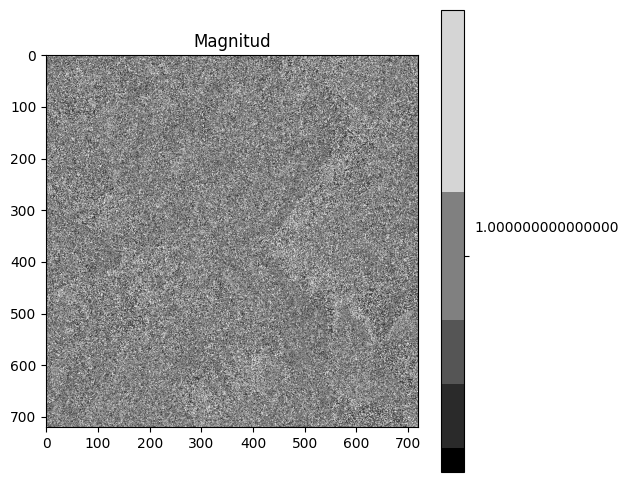

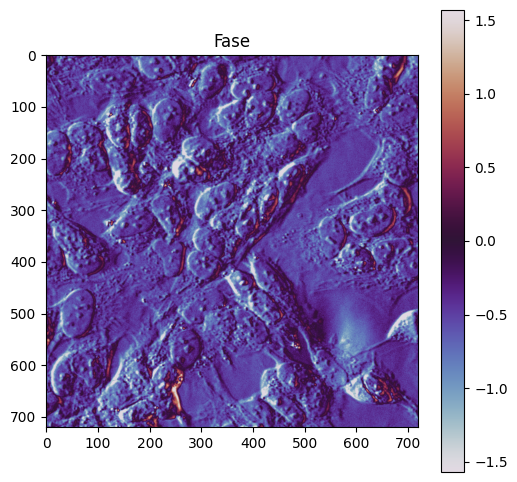

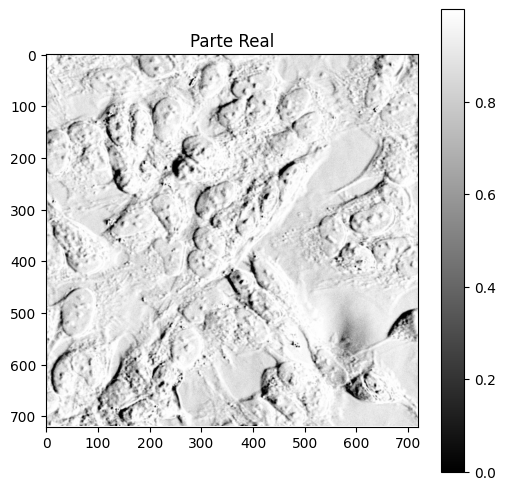

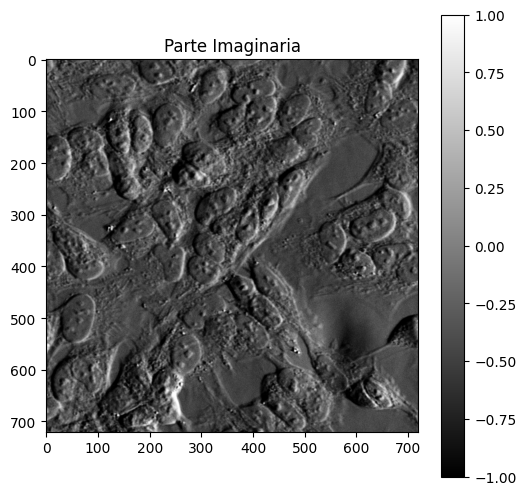

In [34]:
matriz_datos = matriz_datos

# 2. Calcular propiedades relevantes
magnitud = np.abs(matriz_datos)  # Magnitud
fase = np.angle(matriz_datos)    # Fase
real = np.real(matriz_datos)     # Parte real
imaginaria = np.imag(matriz_datos)  # Parte imaginaria

# 3. Visualizar la magnitud
plt.figure(figsize=(6, 6))
plt.imshow(magnitud, cmap='gray')
plt.title('Magnitud')
plt.colorbar()
plt.show()

# 4. Visualizar la fase
plt.figure(figsize=(6, 6))
plt.imshow(fase, cmap='twilight')  # Mapa de colores para fases
plt.title('Fase')
plt.colorbar()
plt.show()

# 5. Visualizar las partes real e imaginaria
plt.figure(figsize=(6, 6))
plt.imshow(real, cmap='gray')
plt.title('Parte Real')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(imaginaria, cmap='gray')
plt.title('Parte Imaginaria')
plt.colorbar()
plt.show()

# 6. Guardar las representaciones como imágenes
plt.imsave("magnitud.png", magnitud, cmap='gray')
plt.imsave("fase.png", fase, cmap='twilight')
plt.imsave("parte_real.png", real, cmap='gray')
plt.imsave("parte_imaginaria.png", imaginaria, cmap='gray')

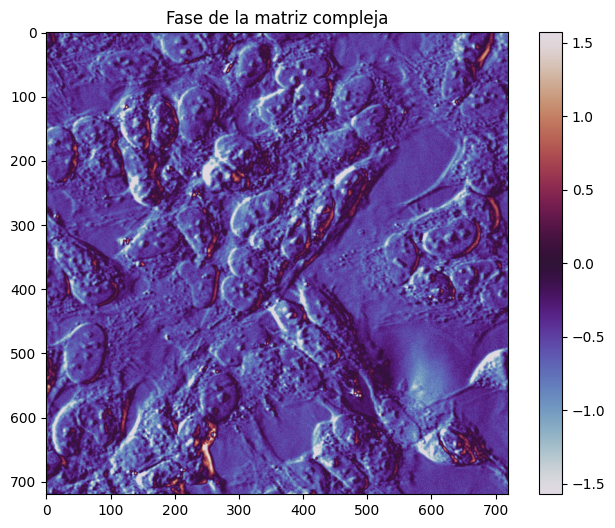

In [35]:
plt.figure(figsize = (8, 6))
plt.imshow(np.angle(matriz_datos), cmap = 'twilight')
plt.colorbar()
plt.title('Fase de la matriz compleja')
plt.show()

In [36]:
print(f"Valores maximos y minimos de la matriz de datos de la imagen: {np.max(matriz_datos)} y {np.min(matriz_datos)}")

Valores maximos y minimos de la matriz de datos de la imagen: (0.999981027348727+0.00615994663813863j) y (6.12323399573677e-17-1j)


In [37]:
print(f"Forma de la matriz de datos de la imagen: {np.shape(matriz_datos)}")

Forma de la matriz de datos de la imagen: (720, 720)


Una imagen generada a partor de las fases, magnitudes y saturación, hsv:

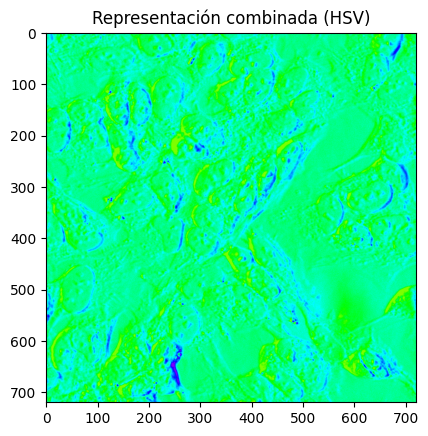

In [38]:
from matplotlib.colors import hsv_to_rgb

# Crear un mapa HSV
hsv = np.zeros((*magnitud.shape, 3))  # Crear un mapa HSV
hsv[..., 0] = (fase + np.pi) / (2 * np.pi)  # Fase normalizada a [0, 1]
hsv[..., 1] = 1  # Saturación fija
hsv[..., 2] = magnitud / np.max(magnitud)  # Magnitud normalizada

# Convertir de HSV a RGB
rgb = hsv_to_rgb(hsv)

# Mostrar la imagen resultante
plt.imshow(rgb)
plt.title('Representación combinada (HSV)')
plt.show()

## ¿Que imagen es la que viaja a traves del sistema optico?

Viaja el campo completo, es decir:

In [39]:
campo_complejo = magnitud * np.exp(1j * fase)

Si mi sistema de lentes lo unico que hace es magnificar o filtrar ruido, ya sabemos como se procede.

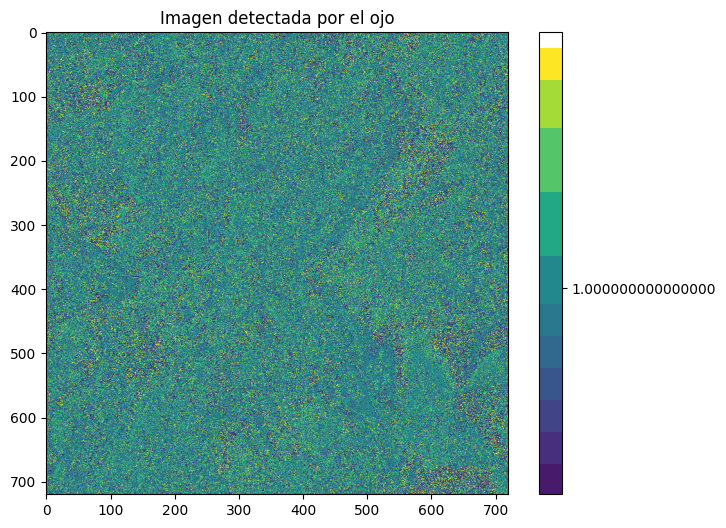

In [40]:
campo = campo_complejo

plt.figure(figsize = (8, 6))
plt.imshow(np.abs(campo)**2, cmap = 'viridis')
plt.colorbar()
plt.title('Imagen detectada por el ojo')
plt.show()

In [41]:
print(f"Valores maximo y minimo de la imagen normalizada: {np.max(campo)} y {np.min(campo)}.")

Valores maximo y minimo de la imagen normalizada: (0.9999810273487268+0.00615994663813863j) y (6.123233995736766e-17-1j).


In [42]:
plt.imsave(r'C:\Users\Felipe\Pictures\Optica_Proyecto\Muestra Biologica.png', campo, cmap = 'magma')

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:788: ComplexWarning: Casting complex values to real discards the imaginary part
  xa = xa.astype(int)


## Mostrando que la imagen se invierte

# Metodo del microscopio de contraste de fase

Dado que es una muestra traslúcida, la luz no sufre cambios de intensidad significativos que nos permitan distinguir detalles, unicamente cambios de fase dados las secciones que se atraviesan de la muestra biológica, por lo cual, el metodo consiste en traducir los desfases en intensidades apreciables.

In [43]:
r_pupil = 10

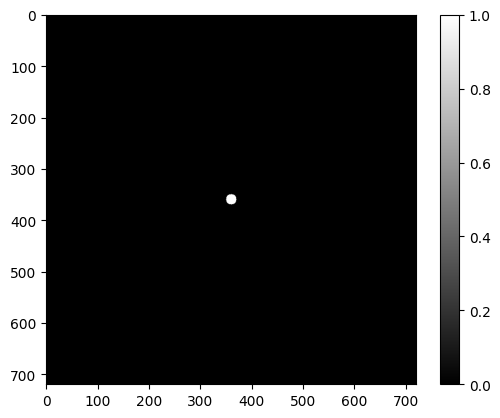

In [44]:
pupila1_muestrabio = np.ones(np.shape(campo), dtype = "uint8")
coordx = int(np.shape(campo)[0]/2)
coordy = int(np.shape(campo)[1]/2)
cv2.circle(pupila1_muestrabio, (coordy, coordx), r_pupil, 0, -1)            # Atención a lo que pasa aqui con las coordenadas

pupila1_muestrabio = ~pupila1_muestrabio

pupila_norm1_muestrabio = normalize_image(pupila1_muestrabio)

plt.imshow(pupila_norm1_muestrabio, cmap = 'gray')
plt.colorbar()
plt.show()

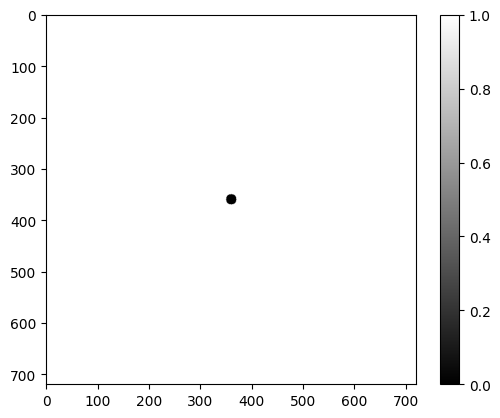

In [45]:
pupila2_muestrabio = np.ones(np.shape(campo), dtype = "uint8")
coordx = int(np.shape(campo)[0]/2)
coordy = int(np.shape(campo)[1]/2)
cv2.circle(pupila2_muestrabio, (coordy, coordx), r_pupil, 0, -1)            # Atención a lo que pasa aqui con las coordenadas

pupila2_muestrabio = pupila2_muestrabio

pupila_norm2_muestrabio = normalize_image(pupila2_muestrabio)

plt.imshow(pupila_norm2_muestrabio, cmap = 'gray')
plt.colorbar()
plt.show()

## Medio refractivo en la pupila

Necesito que la región de bajas frecuencias, se desfase de las regiones de altas frecuencias, por lo que no debo eliminar frecuencias sino multiplicarlas por valores de base diferentes para lograr desfasarlas y que interfieran de manera que se aprecie a la salida.

In [46]:
v_desfase = np.exp(1j * np.pi/2)
zona_desfase = (pupila_norm1_muestrabio * v_desfase) + pupila_norm2_muestrabio

No tiene sentido graficarlo porque no se puede ver, como intensidad.

In [47]:
print(f"Valor máximo y minimo de la zona de desfase: {np.max(zona_desfase)}  y {np.min(zona_desfase)}")

Valor máximo y minimo de la zona de desfase: (1+0j)  y (6.123233995736766e-17+1j)


Al parecer el comando de np.angle() lo calcula por la formula de euler y por lo tanto el valor se distribuye de una manera diferente a lo que se espera.

## Implementación de la pupila para el desfase

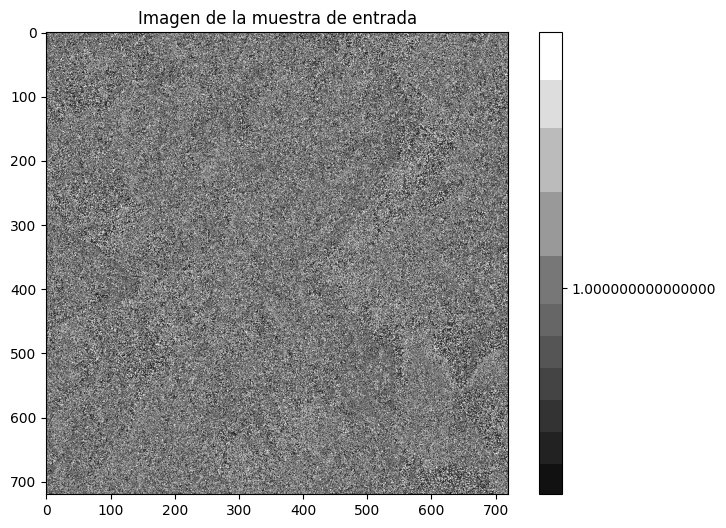

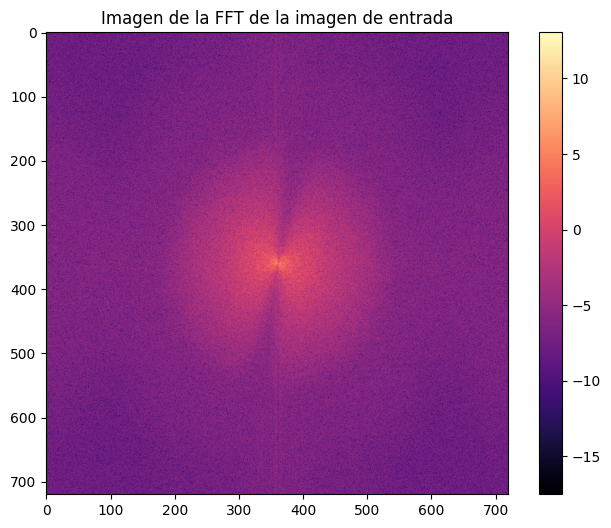

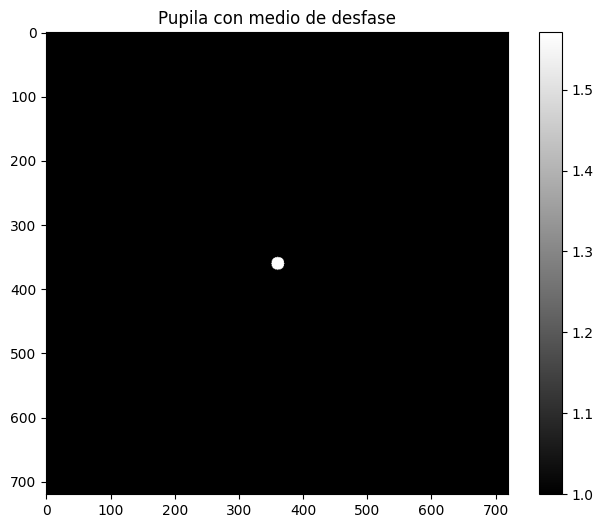

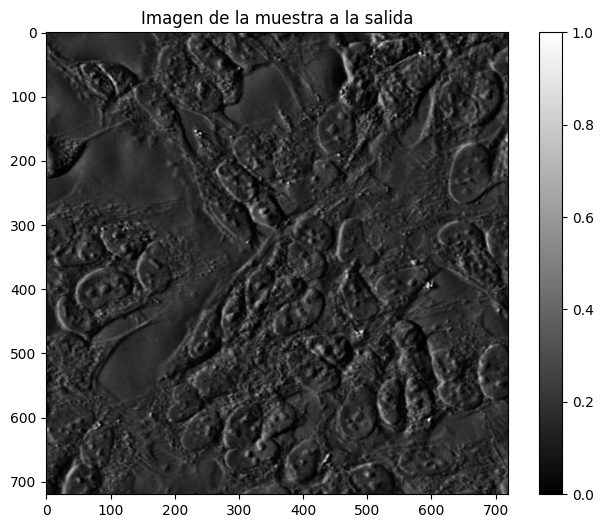

In [48]:
fft_muestrabio = fftshift(fft2(campo, norm = "ortho"))

espectro_desfasado = fft_muestrabio * zona_desfase

img_muestrabio_salida = fft2(espectro_desfasado, norm = "ortho")   # fft2 directa, pues el efecto del lente relativo al sistema es una fft

intensidad_salida = normalize_image(np.abs(img_muestrabio_salida)**2) # directa como en el primer lente
intensidad_campo = np.abs(campo)**2

plt.figure(figsize = (8, 6))
plt.imshow(np.abs(campo)**2, cmap = 'gray')
plt.title('Imagen de la muestra de entrada')
plt.colorbar()
plt.axis()
plt.show()

plt.figure(figsize = (8, 6))
plt.imshow(np.log(0.00000001 + np.abs(fft_muestrabio)**2), cmap = 'magma')
plt.title('Imagen de la FFT de la imagen de entrada')
plt.colorbar()
plt.axis()
plt.show()

plt.figure(figsize = (8, 6))
plt.imshow(np.angle(zona_desfase) + pupila_norm2_muestrabio, cmap = 'gray')
plt.title('Pupila con medio de desfase')
plt.colorbar()
plt.axis()
plt.show()


plt.figure(figsize = (8, 6))
plt.imshow(intensidad_salida, cmap = 'gray')
plt.title('Imagen de la muestra a la salida')
plt.colorbar()
plt.axis()
plt.show()

### Todas las imagenes de los planos importantes están en el bloque de texto anterior, recordar desplazar hacia arriba o hacia abajo para poder verlas

### Verificando si son correspondientes

In [49]:
# Verifica si la imagen es igual (dentro de un margen de tolerancia)
original = intensidad_campo
invertida = np.fft.ifft2(np.fft.fft2(intensidad_campo)).real  # Asegúrate de tomar la parte real
print(np.allclose(original, invertida))  # Debería ser True si todo está correcto

True


Se logra ver como la imagen resultante está invertida, siempre y cuando el espectro tomado por el lente 2, esté en su plano focal.

In [50]:
print(f"Maximo y minimo de la imagen a la salida: {np.max(intensidad_salida)} y {np.min(intensidad_salida)}")

Maximo y minimo de la imagen a la salida: 1.0 y 0.0
